In [ ]:
import os
# Find the latest version of spark 3.0  from http://www.apache.org/dist/spark/ and enter as the spark version
# For example:
spark_version = 'spark-3.0.3'
#spark_version = 'spark-3.<enter version>'
os.environ['SPARK_VERSION']=spark_version

# Install Spark and Java
!apt-get update
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q http://www.apache.org/dist/spark/$SPARK_VERSION/$SPARK_VERSION-bin-hadoop2.7.tgz
!tar xf $SPARK_VERSION-bin-hadoop2.7.tgz
!pip install -q findspark

# Set Environment Variables
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = f"/content/{spark_version}-bin-hadoop2.7"

# Start a SparkSession
import findspark
findspark.init()

Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Get:2 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:4 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:5 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Ign:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [697 B]
Hit:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:10 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Hit:11 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:12 http://archive.ubuntu.com/ubuntu bionic-backpor

In [ ]:
# First, enter the following code to download a Postgres driver that will allow Spark to interact with Postgres:
!wget https://jdbc.postgresql.org/download/postgresql-42.2.16.jar

--2021-08-06 06:09:04--  https://jdbc.postgresql.org/download/postgresql-42.2.16.jar
Resolving jdbc.postgresql.org (jdbc.postgresql.org)... 72.32.157.228, 2001:4800:3e1:1::228
Connecting to jdbc.postgresql.org (jdbc.postgresql.org)|72.32.157.228|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1002883 (979K) [application/java-archive]
Saving to: ‘postgresql-42.2.16.jar’

postgresql-42.2.16. 100%[===================>] 979.38K  --.-KB/s    in 0.1s    

2021-08-06 06:09:05 (6.53 MB/s) - ‘postgresql-42.2.16.jar’ saved [1002883/1002883]



In [ ]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("Regression_Basic").config("spark.driver.extraClassPath","/content/postgresql-42.2.16.jar").getOrCreate()

In [ ]:
# Load in a sql functions
from pyspark.sql.functions import col, avg, sum, count, rand, randn, to_timestamp

In [ ]:
# Read in data from S3 Buckets
from pyspark import SparkFiles
url = "https://tq2cutebucket.s3.us-west-1.amazonaws.com/final_data.csv"
spark.sparkContext.addFile(url)
df = spark.read.option("encoding", "UTF-8").csv(SparkFiles.get("final_data.csv"), sep=",", header=True, inferSchema=True)
df.show(5)
df.count()

+-----------+--------------------+----------+--------+----------+------------+---------+--------+---+----------+---------+---------+---------+---+---------+---------+----------+----------+--------------+--------------+----------+
| MLS_Number|      Street_Address|      City|Zip_Code|    county|County_Index|SqFtTotal|Lot_Size|Age|BathsTotal|BedsTotal|BathsFull|BathsHalf|DOM|Year_List|Year_Sold|List_Price|Sale_Price|  Listing_Date|     Sale_Date|Year_Built|
+-----------+--------------------+----------+--------+----------+------------+---------+--------+---+----------+---------+---------+---------+---+---------+---------+----------+----------+--------------+--------------+----------+
| BE40950609|   2724 Foxglove Ct |Pleasanton|   94588|   Alameda|           8|     2051|  2949.0| 23|         3|        4|        2|        1|  6|     2021|     2021|   1450000|   1625000|5/19/2021 0:00|5/25/2021 0:00|      1998|
| ML81845215|  7873 Chestnut WAY |Pleasanton|   94588|   Alameda|           8|  

4225

In [ ]:
# Drop null values
# This is a safety step in case the data is not perfect
df = df.dropDuplicates(['MLS_Number','Street_Address','City','Zip_Code','county','County_Index','SqFtTotal','Lot_Size','BedsTotal','BathsTotal','BathsFull','BathsHalf','Year_Built','List_Price','Sale_Price'])
df = df.sort("MLS_Number")
df.show(5)
df.count()

+-----------+--------------------+---------+--------+------+------------+---------+--------+---+----------+---------+---------+---------+---+---------+---------+----------+----------+--------------+--------------+----------+
| MLS_Number|      Street_Address|     City|Zip_Code|county|County_Index|SqFtTotal|Lot_Size|Age|BathsTotal|BedsTotal|BathsFull|BathsHalf|DOM|Year_List|Year_Sold|List_Price|Sale_Price|  Listing_Date|     Sale_Date|Year_Built|
+-----------+--------------------+---------+--------+------+------------+---------+--------+---+----------+---------+---------+---------+---+---------+---------+----------+----------+--------------+--------------+----------+
|BA321014028|807 Dizzy Gillesp...|  Windsor|   95492|Sonoma|          20|     1520|  4400.0| 22|         2|        3|        2|        0|  0|     2021|     2021|    629000|    650000|5/23/2021 0:00|5/23/2021 0:00|      1999|
|BA321014324|  300 Via La Cumbre |Greenbrae|   94904| Marin|          15|     2419|  7479.0| 58|    

4225

In [ ]:
# Convert data to pandas db
reg_pd_df=df.toPandas()
reg_pd_df.head(5)

,MLS_Number,Street_Address,City,Zip_Code,county,County_Index,SqFtTotal,Lot_Size,Age,BathsTotal,BedsTotal,BathsFull,BathsHalf,DOM,Year_List,Year_Sold,List_Price,Sale_Price,Listing_Date,Sale_Date,Year_Built
0,BA321014028,807 Dizzy Gillespie WAY,Windsor,95492,Sonoma,20,1520,4400.0,22,2,3,2,0,0,2021,2021,629000,650000,5/23/2021 0:00,5/23/2021 0:00,1999
1,BA321014324,300 Via La Cumbre,Greenbrae,94904,Marin,15,2419,7479.0,58,3,4,3,0,9,2021,2021,1299000,1460000,5/18/2021 0:00,5/27/2021 0:00,1963
2,BA321015460,238 Brookdale DR,Vacaville,95687,Solano,16,1226,8969.0,36,2,3,2,0,37,2021,2021,449977,470000,2/1/2021 0:00,3/10/2021 0:00,1985
3,BA321015670,2 Alpine RD,Novato,94945,Marin,15,2892,43560.0,138,4,4,4,0,7,2021,2021,1599000,1781883,5/18/2021 0:00,5/25/2021 0:00,1883
4,BA321019503,19355 Orange AVE,Sonoma,95476,Sonoma,20,2339,76666.0,69,2,3,2,0,8,2021,2021,1600000,1650000,5/17/2021 0:00,5/25/2021 0:00,1952


In [ ]:
# Built the dataframe of tested items
# Select the column needed
# Need this dataframe later to append the talbe of testing variables
county_index_pyspark = df.select('county','County_Index').drop_duplicates().sort('county')
county_index_pyspark.show(50)
county_index_pyspark.count()

+---------------+------------+
|         county|County_Index|
+---------------+------------+
|        Alameda|           8|
|         Amador|          34|
|          Butte|          11|
|      Calaveras|          39|
|         Colusa|          38|
|   Contra Costa|           6|
|      El Dorado|          19|
|         Fresno|          36|
|          Glenn|          41|
|       Imperial|          46|
|           Kern|          32|
|           Lake|          29|
|    Los Angeles|           0|
|         Madera|          28|
|          Marin|          15|
|      Mendocino|          35|
|         Merced|          22|
|       Monterey|          24|
|           Napa|          30|
|         Nevada|          27|
|         Orange|           2|
|         Placer|           9|
|         Plumas|          44|
|      Riverside|           1|
|     Sacramento|           4|
|     San Benito|          33|
| San Bernardino|           3|
|      San Diego|           5|
|  San Francisco|          21|
|    San

46

In [ ]:
#data_df = df.select('MLS_Number','Street_Address','City','Zip_Code','county','County_Index','SqFtTotal','Lot_Size','BedsTotal','BathsTotal','BathsFull','BathsHalf','Year_Built','Sale_Price')
data_df = df.select('county','County_Index','SqFtTotal','Lot_Size','Age','BathsTotal','BedsTotal','BathsFull','BathsHalf','DOM','Year_Sold','List_Price','Sale_Price')
df.dtypes
data_df.count()

4225

In [ ]:
# Import libraries
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

In [ ]:
data_df.show()

+------+------------+---------+--------+---+----------+---------+---------+---------+---+---------+----------+----------+
|county|County_Index|SqFtTotal|Lot_Size|Age|BathsTotal|BedsTotal|BathsFull|BathsHalf|DOM|Year_Sold|List_Price|Sale_Price|
+------+------------+---------+--------+---+----------+---------+---------+---------+---+---------+----------+----------+
|Sonoma|          20|     1520|  4400.0| 22|         2|        3|        2|        0|  0|     2021|    629000|    650000|
| Marin|          15|     2419|  7479.0| 58|         3|        4|        3|        0|  9|     2021|   1299000|   1460000|
|Solano|          16|     1226|  8969.0| 36|         2|        3|        2|        0| 37|     2021|    449977|    470000|
| Marin|          15|     2892| 43560.0|138|         4|        4|        4|        0|  7|     2021|   1599000|   1781883|
|Sonoma|          20|     2339| 76666.0| 69|         2|        3|        2|        0|  8|     2021|   1600000|   1650000|
|Sonoma|          20|   

In [ ]:
data_array = np.array(data_df.collect())

In [ ]:
#Note: skip the listing price here
X = data_array[:,1:12]
y = data_array[:,12:13]
print(X)
print(y)

[['20' '1520' '4400.0' ... '0' '2021' '629000']
 ['15' '2419' '7479.0' ... '9' '2021' '1299000']
 ['16' '1226' '8969.0' ... '37' '2021' '449977']
 ...
 ['0' '780' '13932.0' ... '33' '2021' '1099000']
 ['0' '2159' '37723.0' ... '7' '2021' '2295000']
 ['0' '8918' '13074.0' ... '1' '2021' '13500000']]
[['650000']
 ['1460000']
 ['470000']
 ...
 ['1200000']
 ['2450000']
 ['13500000']]


In [ ]:
#your_array = your_array.astype(np.float64)
X = X.astype(np.float64)
y = y.astype(np.float64)

**SAMPLE SIZE** due to sample size is pretty large, > 4K, 5% of 4K is more than 200 rows. 200 is good enough for testing 

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=5)

In [ ]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(4013, 11) (212, 11) (4013, 1) (212, 1)


In [ ]:
# Fit ML Regression to a traing set
# Forcing intercept to be zero
from sklearn.linear_model import LinearRegression
regression = LinearRegression(fit_intercept=False) # False = no-intercept
regression.fit(X_train, y_train)

# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html
# LinearRegression(copy_X=True, fit_intercept=False, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=False, n_jobs=None, normalize=False)

In [ ]:
# Predicting the test result
y_pred = regression.predict(X_test)

In [ ]:
# Print out the interceptor
# Expect intercept is zero
print("Intercept: " + str(regression.intercept_))

Intercept: 0.0


In [ ]:
# Print out the coefficients
print("Coefficients: " + str(regression.coef_))

Coefficients: [[ 6.57434557e+02 -1.30780502e+01 -7.78347836e-05  6.53969471e+02
  -1.70205803e+03  1.08816226e+04  1.59465227e+03 -3.29671031e+03
  -1.69559030e+02 -9.58901326e+00  1.04113333e+00]]


In [ ]:
regression.coef_

array([[ 6.57434557e+02, -1.30780502e+01, -7.78347836e-05,
         6.53969471e+02, -1.70205803e+03,  1.08816226e+04,
         1.59465227e+03, -3.29671031e+03, -1.69559030e+02,
        -9.58901326e+00,  1.04113333e+00]])

In [ ]:
# trying to build a df of coefficient table of name and coefficient values
# initialise data of lists.
#data = {'Name':['Tom', 'nick', 'krish', 'jack'],
#        'Age':[20, 21, 19, 18]}
 
# Create DataFrame
#df = pd.DataFrame(data)
 
# Print the output.
#df

#data_coeff = {'Name':['County_Index','SqFtTotal','Lot_Size','Age','BathsTotal','BedsTotal','BathsFull','BathsHalf','DOM','Year_Sold','List_Price'],
#       'Coefficient':[regression.coef_]}

#coeff_df = pd.DataFrame(data_coeff)

#coeff_df

In [ ]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
#
print("MSE -- Mean Squared Error: " + str(mean_squared_error(y_test, y_pred)))
print("r2 -- R squared: " + str(r2_score(y_test, y_pred)))

MSE -- Mean Squared Error: 118418552908.09721
r2 -- R squared: 0.9533854383010042


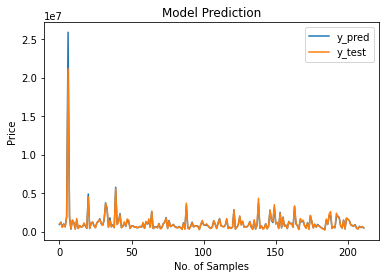

In [ ]:
import matplotlib.pyplot as plt
plt.plot(y_pred)
plt.plot(y_test)
plt.title('Model Prediction')
plt.ylabel('Price')
plt.xlabel('No. of Samples')
plt.legend(['y_pred', 'y_test'], loc='upper right')
plt.show()

**print out a list of predicted price for the x-test data points**

In [ ]:
# Built the dataframe of tested rows

#pandasDF = pysparkDF.toPandas()
county_index_df = county_index_pyspark.toPandas()

# create a panda df from the X_test information
test_data_df = pd.DataFrame(X_test,columns=['County_Index','SqFtTotal','Lot_Size','Age','BathsTotal','BedsTotal','BathsFull','BathsHalf','DOM','Year_Sold','List_Price'])

#df = create a df of Sales_Price and Prediction values
import pandas as pd
good_result_df = pd.DataFrame({"Sale_Price": [x[0] for x in y_test], "Prediction": [x[0] for x in y_pred]})
good_result_df['Prediction'] = good_result_df['Prediction'].map('{:,.2f}'.format)

# This is the final data frame. Merge two df to match the independent variables and the predicted price
final_result_data_df = test_data_df.merge(good_result_df, how='left', left_index=True, right_index=True)

#result = pd.merge(left, right, on="key")
final_add_county_df = pd.merge(county_index_df, final_result_data_df, on="County_Index")
final_add_county_df.head(20)

#pandasDF = pysparkDF.toPandas()
#sparkDF=spark.createDataFrame(pandasDF)
reg_test_prediction_df = spark.createDataFrame(final_add_county_df)
reg_test_prediction_df.show(10)


+-------+------------+---------+--------+-----+----------+---------+---------+---------+----+---------+----------+----------+------------+
| county|County_Index|SqFtTotal|Lot_Size|  Age|BathsTotal|BedsTotal|BathsFull|BathsHalf| DOM|Year_Sold|List_Price|Sale_Price|  Prediction|
+-------+------------+---------+--------+-----+----------+---------+---------+---------+----+---------+----------+----------+------------+
|Alameda|           8|   1650.0|  7763.0| 48.0|       2.0|      4.0|      2.0|      0.0| 8.0|   2021.0| 1228888.0| 1650000.0|1,317,082.69|
|Alameda|           8|   1610.0|  7000.0| 53.0|       2.0|      3.0|      2.0|      0.0| 6.0|   2021.0|  850000.0|  930000.0|  915,860.29|
|Alameda|           8|   1325.0|  4988.0| 33.0|       2.0|      3.0|      2.0|      0.0| 5.0|   2021.0|  799000.0| 1020000.0|  853,580.06|
|Alameda|           8|   1116.0|  6555.0| 61.0|       2.0|      3.0|      2.0|      0.0|16.0|   2021.0|  895000.0|  840000.0|  972,708.05|
|Alameda|           8|   17

**SECTION 2** generate a list of predicted value for **ALL** the data points

In [ ]:
# Predicting the price for all
y_pred_all = regression.predict(X)
print(y_pred_all)

[[  675580.56614355]
 [ 1390886.4044729 ]
 [  493290.49531826]
 ...
 [ 1195845.65097877]
 [ 2414459.35810778]
 [13971387.68060188]]


In [ ]:
# Convert data to pandas db
reg_pd_df=df.toPandas()
reg_pd_df.head(5)

,MLS_Number,Street_Address,City,Zip_Code,county,County_Index,SqFtTotal,Lot_Size,Age,BathsTotal,BedsTotal,BathsFull,BathsHalf,DOM,Year_List,Year_Sold,List_Price,Sale_Price,Listing_Date,Sale_Date,Year_Built
0,BA321014028,807 Dizzy Gillespie WAY,Windsor,95492,Sonoma,20,1520,4400.0,22,2,3,2,0,0,2021,2021,629000,650000,5/23/2021 0:00,5/23/2021 0:00,1999
1,BA321014324,300 Via La Cumbre,Greenbrae,94904,Marin,15,2419,7479.0,58,3,4,3,0,9,2021,2021,1299000,1460000,5/18/2021 0:00,5/27/2021 0:00,1963
2,BA321015460,238 Brookdale DR,Vacaville,95687,Solano,16,1226,8969.0,36,2,3,2,0,37,2021,2021,449977,470000,2/1/2021 0:00,3/10/2021 0:00,1985
3,BA321015670,2 Alpine RD,Novato,94945,Marin,15,2892,43560.0,138,4,4,4,0,7,2021,2021,1599000,1781883,5/18/2021 0:00,5/25/2021 0:00,1883
4,BA321019503,19355 Orange AVE,Sonoma,95476,Sonoma,20,2339,76666.0,69,2,3,2,0,8,2021,2021,1600000,1650000,5/17/2021 0:00,5/25/2021 0:00,1952


In [ ]:
# create a panda df from the all information
# predict_all_df = pd.DataFrame(df,columns=['MLS_Number','Street_Address','City','Zip_Code','county','County_Index','SqFtTotal','Lot_Size','BedsTotal','BathsTotal','BathsFull','BathsHalf','Year_Built','List_Price'])

#df = create a df of Sales_Price and Prediction values
import pandas as pd
result_all_df = pd.DataFrame({"Sale_Price": [x[0] for x in y], "Predicted_Value": [x[0] for x in y_pred_all]})
result_all_df['Predicted_Value'] = result_all_df['Predicted_Value'].map('{:,.2f}'.format)
result_all_df.head(10)

,Sale_Price,Predicted_Value
0,650000.0,"675,580.57"
1,1460000.0,"1,390,886.40"
2,470000.0,"493,290.50"
3,1781883.0,"1,749,586.95"
4,1650000.0,"1,705,184.57"
5,1150000.0,"1,061,805.75"
6,5000000.0,"5,232,892.59"
7,5050000.0,"5,041,783.83"
8,875000.0,"824,083.75"
9,490000.0,"517,640.11"


In [ ]:
# This is the final data frame. Merge two df to match the independent variables and the predicted price
#result = pd.merge(left, right, on="key")
#final_all_prediction_df = reg_pd_df.merge(result_all_df, how='left', left_index=True, right_index=True)
#final_all_prediction_df.head(5)

final_all_prediction_df = pd.merge(reg_pd_df, result_all_df, on="Sale_Price")

# Remove two columns name is 'C' and 'D'
# df.drop(['A'], axis = 1)
#final_all_prediction_df = final_all_prediction_df.drop(['Sale_Price_y'], axis = 1)
final_all_prediction_df.head(5)

,MLS_Number,Street_Address,City,Zip_Code,county,County_Index,SqFtTotal,Lot_Size,Age,BathsTotal,BedsTotal,BathsFull,BathsHalf,DOM,Year_List,Year_Sold,List_Price,Sale_Price,Listing_Date,Sale_Date,Year_Built,Predicted_Value
0,BA321014028,807 Dizzy Gillespie WAY,Windsor,95492,Sonoma,20,1520,4400.0,22,2,3,2,0,0,2021,2021,629000,650000,5/23/2021 0:00,5/23/2021 0:00,1999,"675,580.57"
1,BA321014028,807 Dizzy Gillespie WAY,Windsor,95492,Sonoma,20,1520,4400.0,22,2,3,2,0,0,2021,2021,629000,650000,5/23/2021 0:00,5/23/2021 0:00,1999,"765,509.92"
2,BA321014028,807 Dizzy Gillespie WAY,Windsor,95492,Sonoma,20,1520,4400.0,22,2,3,2,0,0,2021,2021,629000,650000,5/23/2021 0:00,5/23/2021 0:00,1999,"662,939.47"
3,BA321014028,807 Dizzy Gillespie WAY,Windsor,95492,Sonoma,20,1520,4400.0,22,2,3,2,0,0,2021,2021,629000,650000,5/23/2021 0:00,5/23/2021 0:00,1999,"672,423.77"
4,BA321014028,807 Dizzy Gillespie WAY,Windsor,95492,Sonoma,20,1520,4400.0,22,2,3,2,0,0,2021,2021,629000,650000,5/23/2021 0:00,5/23/2021 0:00,1999,"652,314.25"


In [ ]:
# Review before export
# This is a df of the tested items, not of the whole list
reg_test_prediction_df.show(5)
#reg_test_prediction_df.count()

+-------+------------+---------+--------+----+----------+---------+---------+---------+----+---------+----------+----------+------------+
| county|County_Index|SqFtTotal|Lot_Size| Age|BathsTotal|BedsTotal|BathsFull|BathsHalf| DOM|Year_Sold|List_Price|Sale_Price|  Prediction|
+-------+------------+---------+--------+----+----------+---------+---------+---------+----+---------+----------+----------+------------+
|Alameda|           8|   1650.0|  7763.0|48.0|       2.0|      4.0|      2.0|      0.0| 8.0|   2021.0| 1228888.0| 1650000.0|1,317,082.69|
|Alameda|           8|   1610.0|  7000.0|53.0|       2.0|      3.0|      2.0|      0.0| 6.0|   2021.0|  850000.0|  930000.0|  915,860.29|
|Alameda|           8|   1325.0|  4988.0|33.0|       2.0|      3.0|      2.0|      0.0| 5.0|   2021.0|  799000.0| 1020000.0|  853,580.06|
|Alameda|           8|   1116.0|  6555.0|61.0|       2.0|      3.0|      2.0|      0.0|16.0|   2021.0|  895000.0|  840000.0|  972,708.05|
|Alameda|           8|   1729.0|  

In [ ]:
# CONVERT to pyspark for export
#pandasDF = pysparkDF.toPandas()
#sparkDF= spark.createDataFrame(pandasDF)
final_prediction_df = spark.createDataFrame(final_all_prediction_df)
final_prediction_df.show(5)
# This is the whole list

+-----------+--------------------+-------+--------+------+------------+---------+--------+---+----------+---------+---------+---------+---+---------+---------+----------+----------+--------------+--------------+----------+---------------+
| MLS_Number|      Street_Address|   City|Zip_Code|county|County_Index|SqFtTotal|Lot_Size|Age|BathsTotal|BedsTotal|BathsFull|BathsHalf|DOM|Year_List|Year_Sold|List_Price|Sale_Price|  Listing_Date|     Sale_Date|Year_Built|Predicted_Value|
+-----------+--------------------+-------+--------+------+------------+---------+--------+---+----------+---------+---------+---------+---+---------+---------+----------+----------+--------------+--------------+----------+---------------+
|BA321014028|807 Dizzy Gillesp...|Windsor|   95492|Sonoma|          20|     1520|  4400.0| 22|         2|        3|        2|        0|  0|     2021|     2021|    629000|    650000|5/23/2021 0:00|5/23/2021 0:00|      1999|     675,580.57|
|BA321014028|807 Dizzy Gillesp...|Windsor|  

**END**

**Only activate two lower cells if you want to store data**

In [ ]:
# Store environmental variable
from getpass import getpass
password = getpass('Enter database password')
# Configure settings for RDS
mode = "append"
jdbc_url="jdbc:postgresql://database-1.cvmp56um73d3.us-west-1.rds.amazonaws.com:5432/Final_Project_db"
config = {"user":"postgres",
          "password": password,
          "driver":"org.postgresql.Driver"}

# Write DataFrame to house table in RDS
# export_prediction_df.write.jdbc(url=jdbc_url, table='final_data_prediction', mode=mode, properties=config)

Enter database password··········


In [ ]:
# Write DataFrame to house table in RDS
reg_test_prediction_df.write.jdbc(url=jdbc_url, table='test_prediction', mode=mode, properties=config)
type(reg_test_prediction_df)

pyspark.sql.dataframe.DataFrame

In [ ]:
# Write DataFrame to house table in RDS
final_prediction_df.write.jdbc(url=jdbc_url, table='final_prediction_all', mode=mode, properties=config)
type(final_prediction_df)


pyspark.sql.dataframe.DataFrame